In [1]:
from __future__ import print_function
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy import stats

topdir = os.path.dirname(os.path.abspath("__file__"))
analysis_dir = os.path.join(topdir,"analysis_root_files")
data_pklname = os.path.join(analysis_dir,"tempScanSiDetRun2.pkl")
SPE_pklname = os.path.join(analysis_dir,"tempScanSiDetRun2SPE.pkl")

with open(data_pklname, 'rb') as f:
    df = pickle.load(f)
df = df.query("VoverN > 2.0").reset_index()

with open(SPE_pklname, 'rb') as f:
    df_SPE_clean = pickle.load(f)
    df_54V_Temp = pickle.load(f)
    df_55V_Temp = pickle.load(f)
    df_Vbd = pickle.load(f)

runs = df['run'].unique()
runs = np.sort(runs)
FEBs = df['FEB'].unique()
FEBs = np.sort(FEBs)
tempSetups = df['tempSetup'].unique()
tempSetups = np.sort(tempSetups)

bad_channels = [ 7, 10, 18, 19, 37]

def func_lin(x, k, b):
    return k*x+b

def func_quad(x, a, b, c):
    return a*x*x+b*x+c

For any given run, assume the LED photon emission per pulse is $\Phi$. The SiPM on the monitoring CMB0 has geometry factor $\lambda_0$. It is set at a constant voltage $V_{set,0}$. Its efficiency (quantum efficiency + crosstalk + other effects, which is really the ratio between the detected number of photons to the input) $\epsilon_0$ is a function of overvoltage $\epsilon_0(V_{over,0})$, which in turn is a function of temperature $T_0$, i.e., 
$$V_{over,0} = V_{set,0} - V_{bd}(T_0) = V_{set,0} - (U_{0}+kT_0)$$
Using the SPE values, the overvoltages can be calculated.\
Then in run j, the light yield on this SiPM on CMB0 is 
$$Y_{0, j} = \Phi_j \cdot \lambda_0 \cdot \epsilon_0(V_{set,0} - U_{0}-kT_{0,j})$$
Similarly for the SiPM i in the environment chamber, light yield 
$$Y_{i,j} = \Phi_j \cdot \lambda_i \cdot \epsilon_i(V_{set,i,j} - U_{i}-kT_{i,j})$$
In different runs, $\Phi_j$ can be different so we want to normalize and get rid of it:
$$\frac{Y_{i,j}}{Y_{0,j}} = \frac{\lambda_i \cdot \epsilon_i(V_{set,i,j} - U_{i}-kT_
{i,j})}{\lambda_0 \cdot \epsilon_0(V_{set,0} - U_{0}-kT_{0,j})}$$
Now considering runs $j_1$, $j_2$ taken at the same chamber temperature settings. From the slow control values we can safely approximate that $T_{0,j_1}=T_{0,j_2}$, and $T_{i,j_1}=T_{i,j_2}$. So the overvoltages are the same; $\epsilon_{0,j_1}=\epsilon_{0,j_2}$. (SiPM performance mainly dependent on overvoltage, except noise rate is a funciton of temperature, which is also the same anyways.)\
Thus if we take the ratio,
$$\frac{Y_{i,j_2}}{Y_{0,j_2}}/\frac{Y_{i,j_1}}{Y_{0,j_1}}=\frac{\epsilon_i(V_{set,i,j_2} - U_{i}-kT_{i,j})}{\epsilon_i(V_{set,i,j_1} - U_{i}-kT_{i,j})}$$
In other words, this gives relative light yield (efficiency) ratio at different overvoltages (since at the same temperature the runs scan through different set voltages). Results of different temperatures can be crosschecked.\
For practical purposes, since there are 4 channels used for monitoring and the light yields are different, relative light yields are calculated to a certain run, and $Y_{0,j}$ can be taken as the mean of the relative light yields for each run.

In [2]:
normatemp = 25
df_monitorPEs = df.query("ch < 4").reset_index(drop=True)
df_monitorRefPEs = df_monitorPEs.query("tempSetup==%i"%normatemp).reset_index(drop=True)
monitorRefPEs = []
for chan in range(4):
    df_ = df_monitorRefPEs.query("ch == %i"%chan).reset_index(drop=True)
    monitorRefPEs.append(np.mean(df_['PEs'].astype(float)))
monitorRefPEs = np.array(monitorRefPEs)
print("Monitor CMB, ~room temperature, Vbias = 54.5V")
print("Normalizing using scan runs at chamber temp. of %iC"%normatemp)
display(df_monitorRefPEs)
print(monitorRefPEs)

GetNormalization = lambda chan: monitorRefPEs[chan]
normalization_array = GetNormalization(df_monitorPEs['ch'])
df_monitorPEs.loc[:, 'PEs_normalized'] = np.divide(df_monitorPEs['PEs'], normalization_array)
print("Monitor CMB PEs")
with pd.option_context('display.max_rows', 10,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_monitorPEs)

df_PEsNormalizationFactorByRun = pd.DataFrame(columns=['run', 'norm_factor', 'norm_factor_rms', 'tempCMB'])
for run in runs:
    df_ = df_monitorPEs.query("run==%i"%(run)).reset_index(drop=True)
    norm_factors = df_['PEs_normalized']
    if norm_factors.size != 4:
        print("Run %i sees channel"%run, list(df_monitorPEs['ch']))
    new_row = {'run':run,
               'norm_factor':np.mean(norm_factors),
               'norm_factor_rms':np.std(norm_factors),
               'tempCMB':df_['CMBtemp'][0]}
    df_PEsNormalizationFactorByRun.loc[len(df_PEsNormalizationFactorByRun)] = new_row
print("Light yield normalization by run")
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_PEsNormalizationFactorByRun)

Monitor CMB, ~room temperature, Vbias = 54.5V
Normalizing using scan runs at chamber temp. of 25C


index   run  subrun  FEB  ch   pedestal    calibRaw    calibAdj  \
0     128  1829       0    0   0 -11.235000  376.625000  419.561005   
1     129  1829       0    0   1  17.024099  389.502991  432.148987   
2     130  1829       0    0   2   1.543210  395.863007  438.161011   
3     131  1829       0    0   3  -1.407410  387.260986  430.408997   
4     192  1830       0    0   0 -11.218400  377.018005  419.390015   
5     193  1830       0    0   1  17.198700  389.229004  431.526001   
6     194  1830       0    0   2   1.523140  395.494995  437.837006   
7     195  1830       0    0   3  -1.387730  387.135010  429.968994   
8     256  1831       0    0   0 -11.228500  377.455994  419.631989   
9     257  1831       0    0   1  17.261299  389.808990  432.130005   
10    258  1831       0    0   2   1.562190  396.330994  438.636993   
11    259  1831       0    0   3  -1.379060  387.071991  428.994995   
12    320  1832       0    0   0 -11.192600  376.838013  419.121002   
13    321  1832       0    0   1  17.143299  388.920990  431.639008   
14    322  1832       0    0   2   1.583160  395.467987  438.096985   
15    323  1832       0    0   3  -1.454980  387.445007  430.378998   
16    384  1833       0    0   0 -11.262100  376.802002  419.471008   
17    385  1833       0    0   1  17.063601  389.708008  431.700989   
18    386  1833       0    0   2   1.577370  395.868988  438.164001   
19    387  1833       0    0   3  -1.459530  387.773987  430.592987   
20    448  1834       0    0   0 -11.232000  376.424988  419.151001   
21    449  1834       0    0   1  17.134399  389.166992  431.763000   
22    450  1834       0    0   2   1.532870  394.955994  437.470001   
23    451  1834       0    0   3  -1.379770  386.865997  429.492004   
24    512  1835       0    0   0 -11.306600  377.269989  419.976990   
25    513  1835       0    0   1  17.129101  389.489014  432.054993   
26    514  1835       0    0   2   1.521780  395.673004  438.329987   
27    515  1835       0    0   3  -1.462690  388.485992  431.502991   
28    576  1836       0    0   0 -11.329200  377.339996  419.190002   
29    577  1836       0    0   1  17.118401  389.502014  431.398987   
30    578  1836       0    0   2   1.469130  394.893005  437.259003   
31    579  1836       0    0   3  -1.465670  388.239014  430.733002   

      FEBtemp    CMBtemp      biasV        PEs  PEsCorrected  VoverN  VppN  \
0   47.433334  25.062500  54.253338  54.887486     58.100155     2.5  54.0   
1   47.433334  25.062500  54.253338  63.445820     67.243401     2.5  54.0   
2   47.433334  25.062500  54.253338  65.715958     69.694725     2.5  54.0   
3   47.433334  25.062500  54.253338  54.678356     57.855827     2.5  54.0   
4       47.29  25.062500  54.259998  54.825008     58.118900     3.0  54.5   
5       47.29  25.062500  54.259998  63.485168     67.316406     3.0  54.5   
6       47.29  25.062500  54.259998  65.755905     69.715736     3.0  54.5   
7       47.29  25.062500  54.259998  54.681305     57.891624     3.0  54.5   
8   47.243332  25.062500  54.257782  54.740154     58.056503     3.5  55.0   
9   47.243332  25.062500  54.257782  63.362717     67.187813     3.5  55.0   
10  47.243332  25.062500  54.257782  65.559380     69.511246     3.5  55.0   
11  47.243332  25.062500  54.257782  54.694302     58.043060     3.5  55.0   
12   47.39333  25.062500  54.253338  54.830856     58.148682     4.0  55.5   
13   47.39333  25.062500  54.253338  63.547779     67.328476     4.0  55.5   
14   47.39333  25.062500  54.253338  65.708702     69.646667     4.0  55.5   
15   47.39333  25.062500  54.253338  54.648617     57.857033     4.0  55.5   
16     47.256  25.062500  54.254005  54.850521     58.093651     4.5  56.0   
17     47.256  25.062500  54.254005  63.399837     67.285065     4.5  56.0   
18     47.256  25.062500  54.254005  65.635300     69.596230     4.5  56.0   
19     47.256  25.062500  54.254005  54.543491     57.744724     4.5  56.0   
20  47.160004  25.1160

[54.83797407 63.4615078  65.72848892 54.633255  ]
Monitor CMB PEs


index   run  subrun  FEB  ch  pedestal  calibRaw  calibAdj    FEBtemp  \
0      128  1829       0    0   0   -11.235   376.625   419.561  47.433334   
1      129  1829       0    0   1    17.024   389.503   432.149  47.433334   
2      130  1829       0    0   2     1.543   395.863   438.161  47.433334   
3      131  1829       0    0   3    -1.407   387.261   430.409  47.433334   
4      192  1830       0    0   0   -11.218   377.018   419.390      47.29   
..     ...   ...     ...  ...  ..       ...       ...       ...        ...   
347   6915  1935       0    0   3    -1.375   440.387   427.721   46.75889   
348   6976  1936       0    0   0   -11.125   431.000   418.574   46.90444   
349   6977  1936       0    0   1    17.247   443.070   430.370   46.90444   
350   6978  1936       0    0   2     1.713   451.735   438.650   46.90444   
351   6979  1936       0    0   3    -1.371   438.671   426.426   46.90444   

     CMBtemp   biasV     PEs  PEsCorrected  VoverN  VppN  tempSetup  \
0     25.062  54.253  54.887        58.100     2.5  54.0       25.0   
1     25.062  54.253  63.446        67.243     2.5  54.0       25.0   
2     25.062  54.253  65.716        69.695     2.5  54.0       25.0   
3     25.062  54.253  54.678        57.856     2.5  54.0       25.0   
4     25.062  54.260  54.825        58.119     3.0  54.5       25.0   
..       ...     ...     ...           ...     ...   ...        ...   
347   17.250  54.227  58.924        56.583     5.5  55.1      -10.0   
348   17.250  54.258  59.656        57.268     6.0  55.6      -10.0   
349   17.250  54.258  68.839        66.122     6.0  55.6      -10.0   
350   17.250  54.258  70.465        67.741     6.0  55.6      -10.0   
351   17.250  54.258  59.142        56.757     6.0  55.6      -10.0   

     tempSensor  PEs_normalized  
0          25.0           1.001  
1          25.0           1.000  
2          25.0           1.000  
3          25.0           1.001  
4          25.0           1.000  
..          ...             ...  
347        -9.4           1.079  
348        -9.4           1.088  
349        -9.4           1.085  
350        -9.4           1.072  
351        -9.4           1.083  

[352 rows x 18 columns]

Light yield normalization by run


run  norm_factor  norm_factor_rms  tempCMB
0   1829        1.000        5.426e-04   25.062
1   1830        1.000        3.966e-04   25.062
2   1831        0.999        1.390e-03   25.062
3   1832        1.000        6.459e-04   25.062
4   1833        0.999        7.227e-04   25.062
5   1834        1.001        5.248e-04   25.116
6   1835        1.000        7.297e-04   25.125
7   1836        1.001        1.507e-03   25.062
8   1839        0.988        2.141e-03   26.375
9   1840        0.989        2.275e-03   26.375
10  1841        0.989        2.222e-03   26.375
11  1842        0.988        2.794e-03   26.323
12  1843        0.988        2.253e-03   26.333
13  1844        0.988        6.407e-04   26.319
14  1845        0.990        1.944e-03   26.312
15  1846        0.988        1.537e-03   26.328
16  1849        0.974        1.956e-03   27.750
17  1850        0.973        1.817e-03   27.756
18  1851        0.974        2.856e-03   27.771
19  1852        0.971        2.505e-03   27.797
20  1853        0.974        2.280e-03   27.760
21  1854        0.975        3.201e-03   27.750
22  1855        0.974        3.094e-03   27.750
23  1856        0.973        2.085e-03   27.750
24  1859        0.963        2.859e-03   28.771
25  1860        0.962        3.049e-03   28.769
26  1861        0.966        4.197e-03   28.750
27  1862        0.964        4.744e-03   28.750
28  1863        0.965        2.453e-03   28.725
29  1864        0.963        4.945e-03   28.688
30  1865        0.964        3.291e-03   28.698
31  1866        0.964        2.842e-03   28.688
32  1869        1.015        2.089e-03   24.000
33  1870        1.015        2.006e-03   24.000
34  1871        1.015        2.169e-03   24.000
35  1872        1.017        1.269e-03   24.000
36  1873        1.016        9.232e-04   24.000
37  1874        1.015        9.133e-04   24.016
38  1875        1.014        1.335e-03   24.025
39  1876        1.016        1.172e-03   24.000
40  1879        1.030        9.133e-04   22.625
41  1880        1.029        2.392e-03   22.625
42  1881        1.031        1.988e-03   22.625
43  1882        1.029        1.895e-03   22.625
44  1883        1.031        2.027e-03   22.625
45  1884        1.030        3.702e-03   22.625
46  1885        1.032        2.155e-03   22.625
47  1886        1.030        1.182e-03   22.625
48  1889        1.041        3.880e-03   21.500
49  1890        1.043        3.804e-03   21.500
50  1891        1.043        4.306e-03   21.500
51  1892        1.042        1.925e-03   21.500
52  1893        1.044        2.815e-03   21.469
53  1894        1.045        2.853e-03   21.458
54  1895        1.043        2.055e-03   21.469
55  1896        1.044        2.621e-03   21.446
56  1899        1.053        3.486e-03   20.438
57  1900        1.054        3.336e-03   20.438
58  1901        1.053        3.060e-03   20.438
59  1902        1.052        3.361e-03   20.438
60  1903        1.054        4.662e-03   20.417
61  1904        1.053        2.252e-03   20.375
62  1905        1.052        3.848e-03   20.420
63  1906        1.053        3.672e-03   20.384
64  1909        1.062        3.172e-03   19.312
65  1910        1.064        3.925e-03   19.312
66  1911        1.063        2.212e-03   19.312
67  1912        1.062        4.520e-03   19.312
68  1913        1.064        4.022e-03   19.273
69  1914        1.064        4.258e-03   19.275
70  1915        1.065        4.944e-03   19.289
71  1916        1.063        4.385e-03   19.263
72  1919        1.074        4.991e-03   18.156
73  1920        1.075        4.009e-03   18.139
74  1921        1.073        5.997e-03   18.175
75  1922        1.074        5.182e-03   18.167
76  1923        1.073        6.389e-03   18.146
77  1924        1.074        5.661e-03   18.175
78  1925        1.075        3.641e-03   18.188
79  1926        1.074        4.637e-03   18.188
80  1929        1.081        5.419e-03   17.281
81  1930        1.081        5.056e-03   17.275
82  1931        1.081

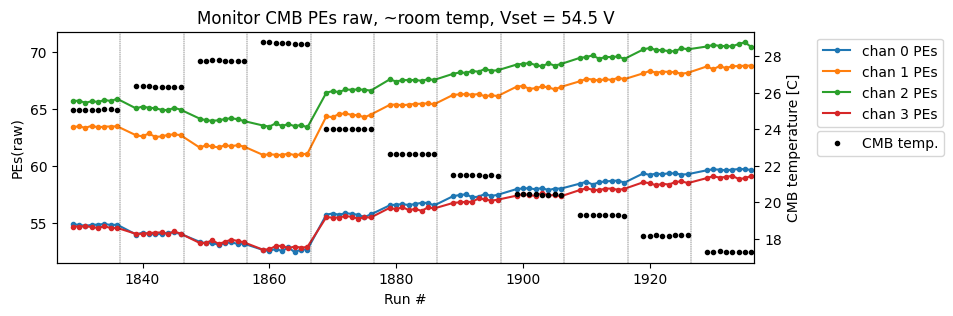

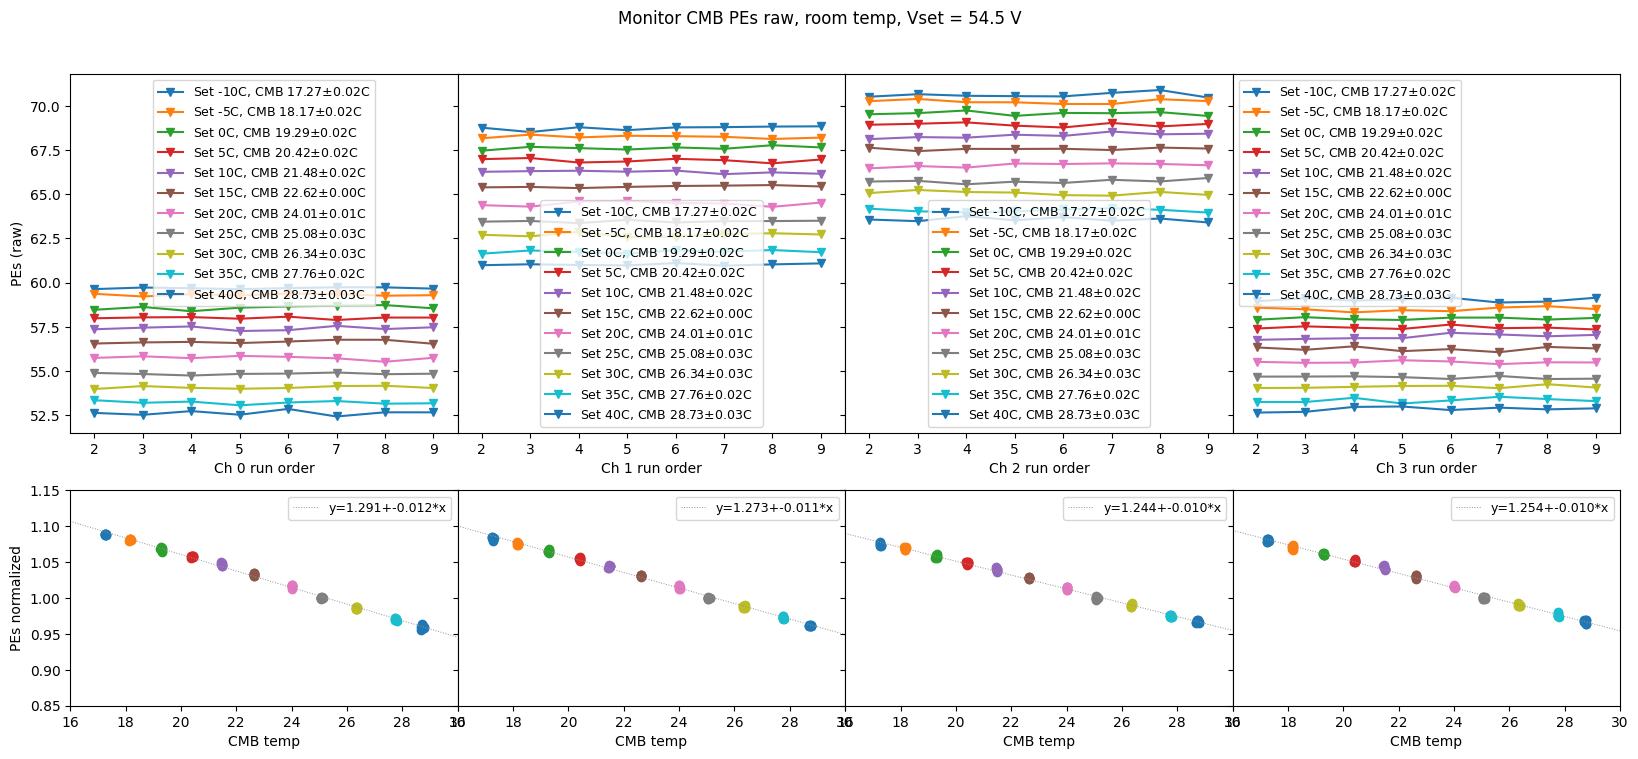

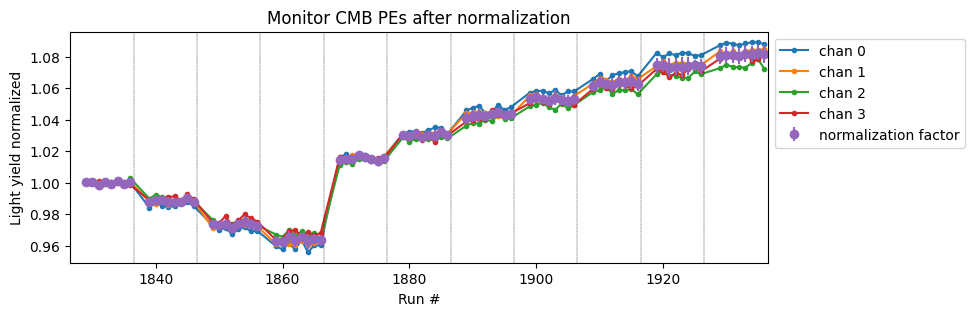

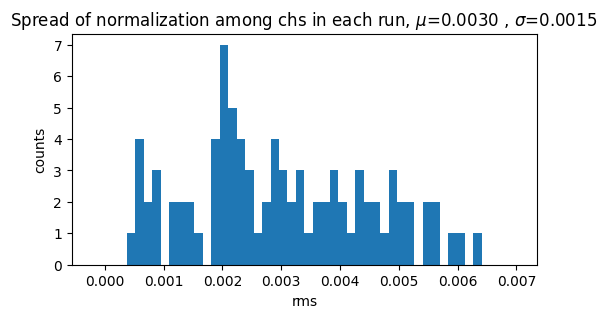

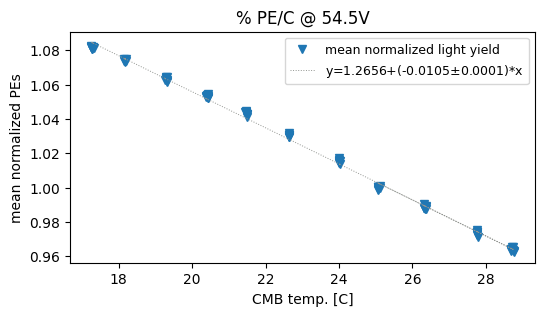

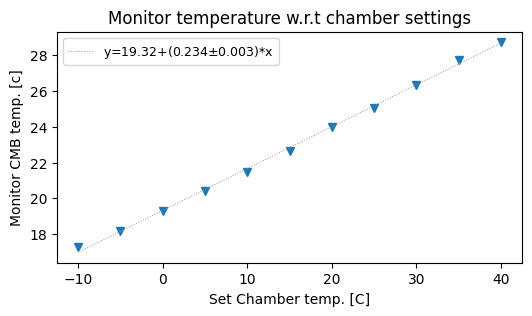

In [3]:
# raw PEs
plt.figure(figsize = (9,3))
for chan in range(4):
    df_ = df_monitorPEs.query('ch == %i'%chan)
    plt.plot(df_['run'], df_['PEs'],'.-',
             label='chan %i PEs'%chan)
plt.title("Monitor CMB PEs raw, ~room temp, Vset = 54.5 V")
plt.xlabel("Run #")
plt.ylabel("PEs(raw)")
plt.gca().set_xlim(np.min(runs)-2.5, np.max(runs)+0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.08, 1.0))
ax2 = plt.gca().twinx()
ax2.plot(df_['run'], df_['CMBtemp'],'.', color='k', linestyle='none', label='CMB temp.')
ax2.set_ylabel("CMB temperature [C]")
plt.legend(loc='upper left', bbox_to_anchor=(1.08, 0.6))
for iTemp in range(11):
    plt.axvline(x=np.min(runs)+10*iTemp-2.5, color='k', linestyle='--', linewidth=0.3)
plt.show()

# grid
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8), sharey='row',
                        gridspec_kw={'width_ratios':[5 for i in range(4)],
                                     'height_ratios':[5,3]})
fig.suptitle("Monitor CMB PEs raw, room temp, Vset = 54.5 V")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.9)
axs[0, 0].set_ylabel("PEs (raw)")
axs[1, 0].set_ylabel("PEs normalized")
for chan in range(4):
    axs[0, chan].set_xlabel('Ch %i run order'%chan)
    axs[1, chan].set_xlabel('CMB temp')
for chan in range(4):
    for tTempSetup in tempSetups:
        df_ = df_monitorPEs.query("ch==%i & tempSetup==%i"%(chan, tTempSetup)).reset_index()
        xx = df_['run'].astype(int)
        xx = xx % (np.min(xx)-2)
        yy = df_['PEs'].astype(float)
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        stdTemp = np.std(df_['CMBtemp'].astype(float))
        
        tscatter = axs[0, chan].plot(xx, yy, 'v-', label=r'Set %.0fC, CMB %.2f$\pm$%.2fC'%(tTempSetup, meanTemp, stdTemp))
        axs[0, chan].set_xlim(1.5,9.5)
        axs[1, chan].plot(df_['CMBtemp'].astype(float), df_['PEs_normalized'].astype(float), 
                          'o', color = tscatter[0].get_color(), linestyle='none')
        axs[1, chan].set_xlim(16.,30.)
        axs[1, chan].set_ylim(0.85,1.15)

    df_ = df_monitorPEs.query("ch==%i"%(chan)).reset_index()
    popt, pcov = curve_fit(func_lin, df_['CMBtemp'].astype(float), df_['PEs_normalized'].astype(float))
    slope = popt[0]
    intercept = popt[1]
    std_err = np.sqrt(pcov[0,0])
    intercept_stderr = np.sqrt(pcov[1,1])
    xx = np.array(list(range(16,32,2)))
    axs[1, chan].plot(xx, slope * xx + intercept, ':', color = '#929591', linewidth=0.7,
                      label='y=%.3f+%.3f*x'%(intercept, slope))

    axs[0, chan].legend(fontsize=9)
    axs[1, chan].legend(fontsize=9)
plt.show()

# normalized light yields
plt.figure(figsize = (9,3))
for chan in range(4):
    df_ = df_monitorPEs.query('ch == %i'%chan)
    plt.plot(df_['run'], df_['PEs_normalized'],'.-',
             label='chan %i'%chan)
plt.errorbar(df_PEsNormalizationFactorByRun['run'], df_PEsNormalizationFactorByRun['norm_factor'],
             yerr = df_PEsNormalizationFactorByRun['norm_factor_rms'],
             marker = 'o', linestyle='none',
             label='normalization factor')
plt.title("Monitor CMB PEs after normalization")
plt.xlabel("Run #")
plt.ylabel("Light yield normalized")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iTemp in range(11):
    plt.axvline(x=np.min(runs)+10*iTemp-2.5, color='k', linestyle='--', linewidth=0.3)
plt.gca().set_xlim(np.min(runs)-2.5, np.max(runs)+0.5)
plt.show()

# spread of normalization in each run among chs
vals = df_PEsNormalizationFactorByRun['norm_factor_rms'].astype(float)
plt.figure(figsize = (6,3))
rangemin = np.min(vals)
rangemax = np.max(vals)
span = rangemax-rangemin
nbins = 50
step = span*1.2/nbins
plt.hist(vals,[rangemin-0.1*span+step*float(i) for i in range(nbins+1)])
plt.title("Spread of normalization among chs in each run, "+r'$\mu$'+"=%.4f "%(np.mean(vals))+r', $\sigma$'+"=%.4f "%(np.std(vals)))
plt.xlabel("rms")
plt.ylabel("counts")
plt.show()

#factor vs temp.
plt.figure(figsize = (6,3))
xx = df_PEsNormalizationFactorByRun['tempCMB'].astype(float)
yy = df_PEsNormalizationFactorByRun['norm_factor'].astype(float)
plt.plot(xx, yy, 'v', linestyle='none', label = 'mean normalized light yield')
popt, pcov = curve_fit(func_lin, xx, yy)
slope = popt[0]
intercept = popt[1]
std_err = np.sqrt(pcov[0,0])
intercept_stderr = np.sqrt(pcov[1,1])
plt.plot(xx, slope * xx + intercept, ':', color = '#929591', linewidth=0.7, label='y=%.4f+(%.4f$\pm$%.4f)*x'%(intercept, slope, std_err))
plt.legend(fontsize=9)
plt.title("% PE/C @ 54.5V")
plt.xlabel("CMB temp. [C]")
plt.ylabel("mean normalized PEs")
plt.show()

#temp vs set temp
CMBtemps = []
for tTempSetup in tempSetups:
    df_ = df_monitorPEs.query("ch==0 & tempSetup==%i"%(tTempSetup)).reset_index()
    meanTemp = np.mean(df_['CMBtemp'].astype(float))
    CMBtemps.append(meanTemp)
CMBtemps = np.array(CMBtemps)
plt.figure(figsize = (6,3))
plt.plot(tempSetups, CMBtemps, 'v', linestyle='none')
popt, pcov = curve_fit(func_lin, tempSetups, CMBtemps)
slope = popt[0]
intercept = popt[1]
std_err = np.sqrt(pcov[0,0])
intercept_stderr = np.sqrt(pcov[1,1])
plt.plot(tempSetups, slope * tempSetups + intercept, ':', color = '#929591', linewidth=0.7, label='y=%.2f+(%.3f$\pm$%.3f)*x'%(intercept, slope, std_err))
plt.legend(fontsize=9)
plt.title("Monitor temperature w.r.t chamber settings")
plt.xlabel("Set Chamber temp. [C]")
plt.ylabel("Monitor CMB temp. [c]")
plt.show()


Quantum efficiency w.r.t overvoltage and overvoltage w.r.t temperature can be slightly different for different channels. As light yield is determined to within 1%, slight divergence in PEs_normalized is acceptable as shown.\
-1.05%/C at 54.5V is consistent with the previous analysis (-1.3%/C @ 54V and -1.0%/C @ 55V). But this value contains both SiPM temperature effect and LED temperature effect.

In [4]:
# Get overvoltage of each run, as well as PEs/Y0
Vover = []
PEsByY0 = []
df_scan = df.query("ch >= 8").reset_index(drop=True)
for index, row in df_scan.iterrows():
    if row['ch'] in bad_channels:
        Vover.append(0)
        PEsByY0.append(0)
    else:
        tChan = row['ch']
        df_Vbd_ = df_Vbd.query("chan == %i"%tChan).reset_index()
        VbdPerC = df_Vbd_['slope'][0]/1000.
        VbdIntercept = df_Vbd_['intercept'][0]
        tTemp = row['CMBtemp']
        tVppN = row['VppN']
        Vover.append(tVppN - (VbdPerC*tTemp+VbdIntercept))
        tRun = row['run']
        tY0 = df_PEsNormalizationFactorByRun.query("run == %i"%tRun).reset_index()['norm_factor'][0]
        PEsByY0.append(row['PEs']/tY0)
# print(Vover)
# print(PEsByY0)
df_scan.loc[:, 'Vover'] = np.array(Vover)
df_scan.loc[:, 'PEsByY0'] = np.array(PEsByY0)

with pd.option_context('display.max_rows', 10,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_scan)

index   run  subrun  FEB  ch  pedestal  calibRaw  calibAdj    FEBtemp  \
0       136  1829       0    0   8    -2.732   316.213   360.780  47.433334   
1       137  1829       0    0   9    -7.283   327.645   372.329  47.433334   
2       138  1829       0    0  10     0.668     0.000     0.000  47.433334   
3       139  1829       0    0  11   -19.096   316.801   362.200  47.433334   
4       140  1829       0    0  12   -12.411   318.976   364.508  47.433334   
...     ...   ...     ...  ...  ..       ...       ...       ...        ...   
4923   7035  1936       0    0  59    -7.444   760.974   564.222   46.90444   
4924   7036  1936       0    0  60    -8.315   750.844   554.073   46.90444   
4925   7037  1936       0    0  61    -4.553   777.971   582.442   46.90444   
4926   7038  1936       0    0  62     2.200   757.938   563.072   46.90444   
4927   7039  1936       0    0  63     8.213   745.764   549.612   46.90444   

      CMBtemp   biasV     PEs  PEsCorrected  VoverN  VppN  tempSetup  \
0      25.406  54.118  16.417        17.420     2.5  54.0       25.0   
1      25.406  54.118   0.000         0.000     2.5  54.0       25.0   
2      25.406  54.118   0.000         0.000     2.5  54.0       25.0   
3      25.406  54.118   0.000         0.000     2.5  54.0       25.0   
4      25.484  54.118  41.171        43.917     2.5  54.0       25.0   
...       ...     ...     ...           ...     ...   ...        ...   
4923   -9.031  55.582  68.456        49.892     6.0  55.6      -10.0   
4924   -9.125  55.582  75.550        54.972     6.0  55.6      -10.0   
4925   -9.125  55.582  67.935        49.338     6.0  55.6      -10.0   
4926   -9.125  55.582  61.119        44.344     6.0  55.6      -10.0   
4927   -9.125  55.582  52.105        37.866     6.0  55.6      -10.0   

      tempSensor  Vover  PEsByY0  
0           25.0  2.591   16.412  
1           25.0  2.630    0.000  
2           25.0  0.000    0.000  
3           25.0  2.623    0.000  
4           25.0  2.592   41.157  
...          ...    ...      ...  
4923        -9.4  6.042   63.280  
4924        -9.4  6.074   69.837  
4925        -9.4  6.131   62.798  
4926        -9.4  6.070   56.498  
4927        -9.4  6.021   48.166  

[4928 rows x 19 columns]

0PE channel: 10 at set temp 5 C
0PE channel: 18 at set temp 35 C
0PE channel: 18 at set temp 40 C
0PE channel: 19 at set temp 5 C
0PE channel: 19 at set temp 25 C
0PE channel: 19 at set temp 30 C
0PE channel: 19 at set temp 40 C
0PE channel: 37 at set temp 25 C
0PE channel: 37 at set temp 35 C
0PE channel: 37 at set temp 40 C


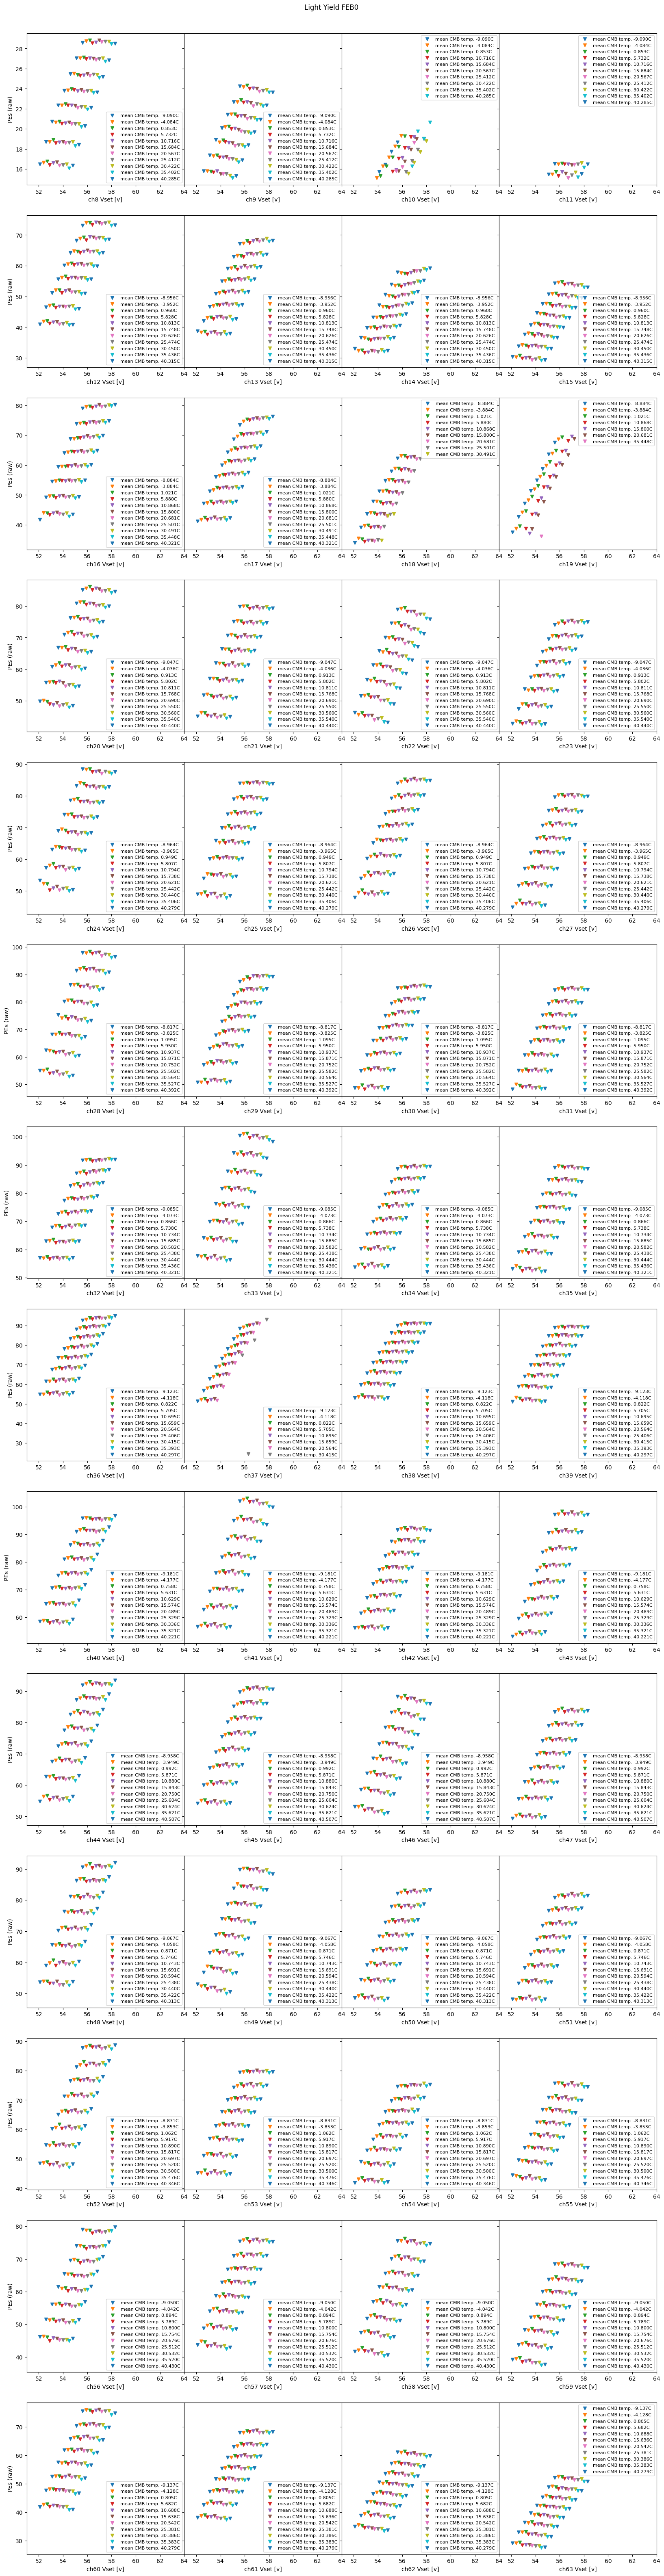

In [5]:
nr = 14
nc = 4

# grid of raw light yield
maintitle = 'Light Yield'
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (5*nc, 5*nr/0.97), sharey = 'row')
plt.suptitle(maintitle+" FEB0")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.97)
ytitle = 'PEs (raw)'
xtitle = 'Vset [v]'
for index, ax in enumerate(axs.flatten()):
    chan = index + 8
    ax.set_xlabel('ch%i '%chan+xtitle)
    if (index%4 == 0):
        ax.set_ylabel(ytitle)
    # if chan in bad_channels:
        # continue
    emptyFlag = True
    for tTempSetup in tempSetups:
        df_ = df_scan.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index()
        xx = df_['VppN'].astype(float)
        yy = df_['PEs'].astype(float)

        # if chan in [36,37,38,39]:
            # print(chan, tTempSetup, yy[yy<50])
            
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        mask = (yy>0)
        xx=xx[mask]
        yy=yy[mask]
        if yy.size==0:
            print("0PE channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if True: #xx.size>3:
            emptyFlag = False
            #tscatter = ax.plot(xx, yy, 'v', label='Set temp. %.0fC, mean CMB temp. %.3fC'%(tTempSetup, meanTemp))
            tscatter = ax.plot(xx, yy, 'v', label='mean CMB temp. %.3fC'%(meanTemp))
            ax.set_xlim(51.,64.)
            # axs.set_ylim(20.,80.)
    if not emptyFlag:
        ax.legend(fontsize=8)
plt.show()

Cannot interpolate channel 11 at set temp -10 C
[5.624456478094324, 6.124025914790693]
Cannot interpolate channel 11 at set temp -5 C
[5.6467431472526215, 6.149757090378031]
Cannot interpolate channel 11 at set temp 0 C
[5.676349392572639, 6.174627139358115]
Cannot interpolate channel 11 at set temp 5 C
[5.606939778832448, 6.106447721502299]
Cannot interpolate channel 11 at set temp 10 C
[5.633150739224142, 6.131871348118551]
Cannot interpolate channel 11 at set temp 15 C
[5.6587096789782265, 6.1582791156745955]
Cannot interpolate channel 11 at set temp 20 C
[5.588229832661121, 6.088918670876133]
Cannot interpolate channel 11 at set temp 25 C
[5.622849680707368, 6.122467051209021]
Cannot interpolate channel 11 at set temp 30 C
[5.647442323301142, 6.145375598420117]
Cannot interpolate channel 11 at set temp 35 C
[5.572915223977105, 6.071192970762581]
Cannot interpolate channel 11 at set temp 40 C
[5.603439990329136, 6.101717737114612]


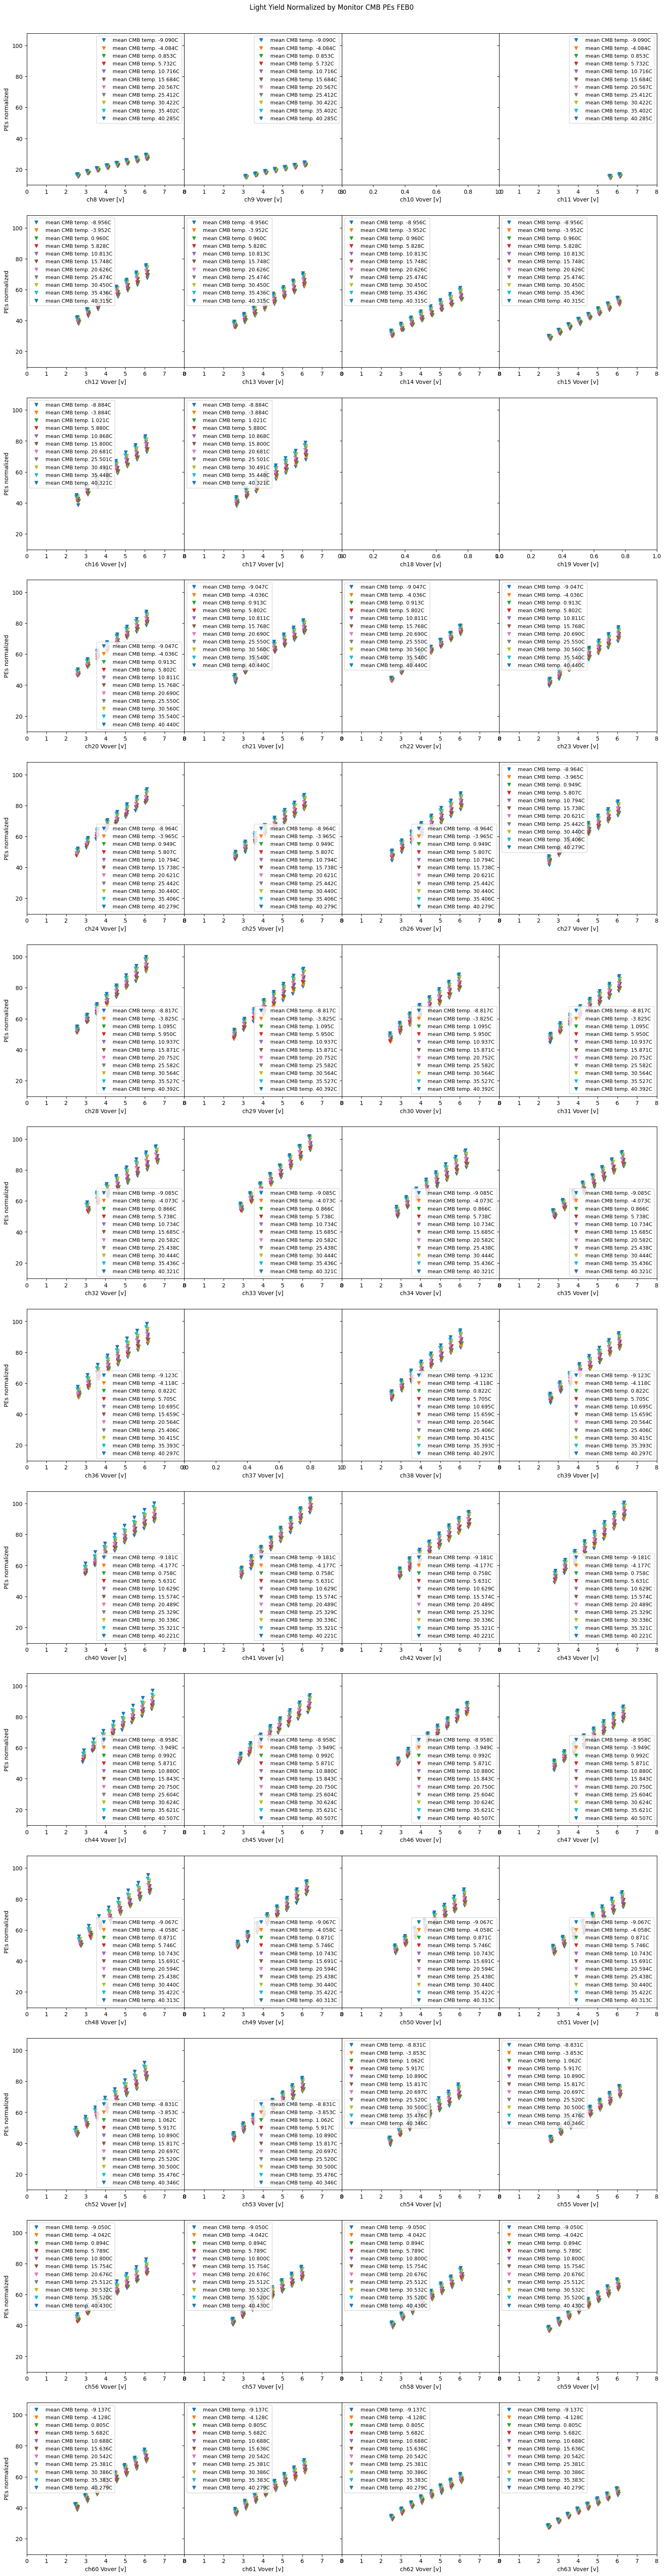

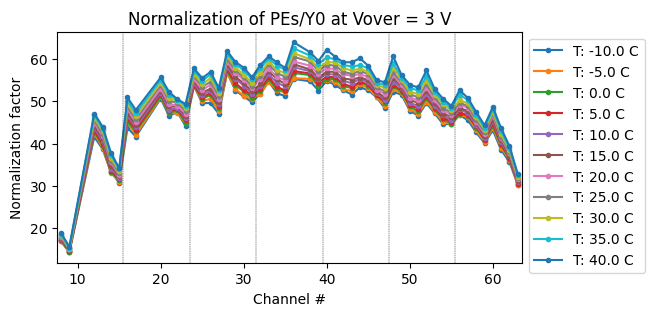

In [6]:
# grid of Yij/Y0j vs Vover
normalization_Vover = 3
df_normalizationAt3VVover = pd.DataFrame(columns=['ch', 'tempSetup', 'normalization'])

maintitle = 'Light Yield Normalized by Monitor CMB PEs'
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (5*nc, 5*nr/0.97), sharey = True)
plt.suptitle(maintitle+" FEB0")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.97)
ytitle = 'PEs normalized'
xtitle = 'Vover [v]'
for index, ax in enumerate(axs.flatten()):
    chan = index + 8
    ax.set_xlabel('ch%i '%chan+xtitle)
    if (index%4 == 0):
        ax.set_ylabel(ytitle)
    if chan in bad_channels:
        continue
    emptyFlag = True
    for tTempSetup in tempSetups:
        df_ = df_scan.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index()
        xx = df_['Vover'].astype(float)
        yy = df_['PEsByY0'].astype(float)
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        mask = (yy>0)
        xx=xx[mask]
        yy=yy[mask]
        if yy.size==0:
            print("0PE channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if True: #xx.size>3:
            emptyFlag = False
            tscatter = ax.plot(xx, yy, 'v', label='mean CMB temp. %.3fC'%(meanTemp))
            ax.set_xlim(0.,8.)
            # axs.set_ylim(20.,80.)
        if xx.size>3 and np.min(xx)<=3.5 and np.max(xx)>=2.5:
            popt, pcov = curve_fit(func_quad, xx.astype(float), yy.astype(float))
            tNormalization = popt[0]*3*3 + popt[1]*3 + popt[2]
            new_row = {'ch':chan, 
                       'tempSetup':tTempSetup, 
                       'normalization':tNormalization}
            df_normalizationAt3VVover.loc[len(df_normalizationAt3VVover)] = new_row            
        else:
            print("Cannot interpolate channel %d at set temp %.0f C"%(chan, tTempSetup))
            print(list(xx))
            new_row = {'ch':chan, 
                       'tempSetup':tTempSetup, 
                       'normalization':0.0}
            df_normalizationAt3VVover.loc[len(df_normalizationAt3VVover)] = new_row      
    if not emptyFlag:
        ax.legend(fontsize=9)
plt.show()

plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_normalizationAt3VVover.query('tempSetup==%f & normalization>0'%temp)
    plt.plot(df_['ch'], df_['normalization'],'.-',
                 label='T: %.1f C'%temp)
plt.title("Normalization of PEs/Y0 at Vover = 3 V")
plt.xlabel("Channel #")
plt.ylabel("Normalization factor")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(1, 8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(7.5, 63+0.5)
plt.show()

From the formulae, we can see the deviations in the above plot is independent of the LED light yield, but still affected by the efficiency differences on the monitoring SiPMs due to temperature changes / geometry of test stand.

Bad normalization channel: 11 at set temp -10 C
Bad normalization channel: 11 at set temp -5 C
Bad normalization channel: 11 at set temp 0 C
Bad normalization channel: 11 at set temp 5 C
Bad normalization channel: 11 at set temp 10 C
Bad normalization channel: 11 at set temp 15 C
Bad normalization channel: 11 at set temp 20 C
Bad normalization channel: 11 at set temp 25 C
Bad normalization channel: 11 at set temp 30 C
Bad normalization channel: 11 at set temp 35 C
Bad normalization channel: 11 at set temp 40 C


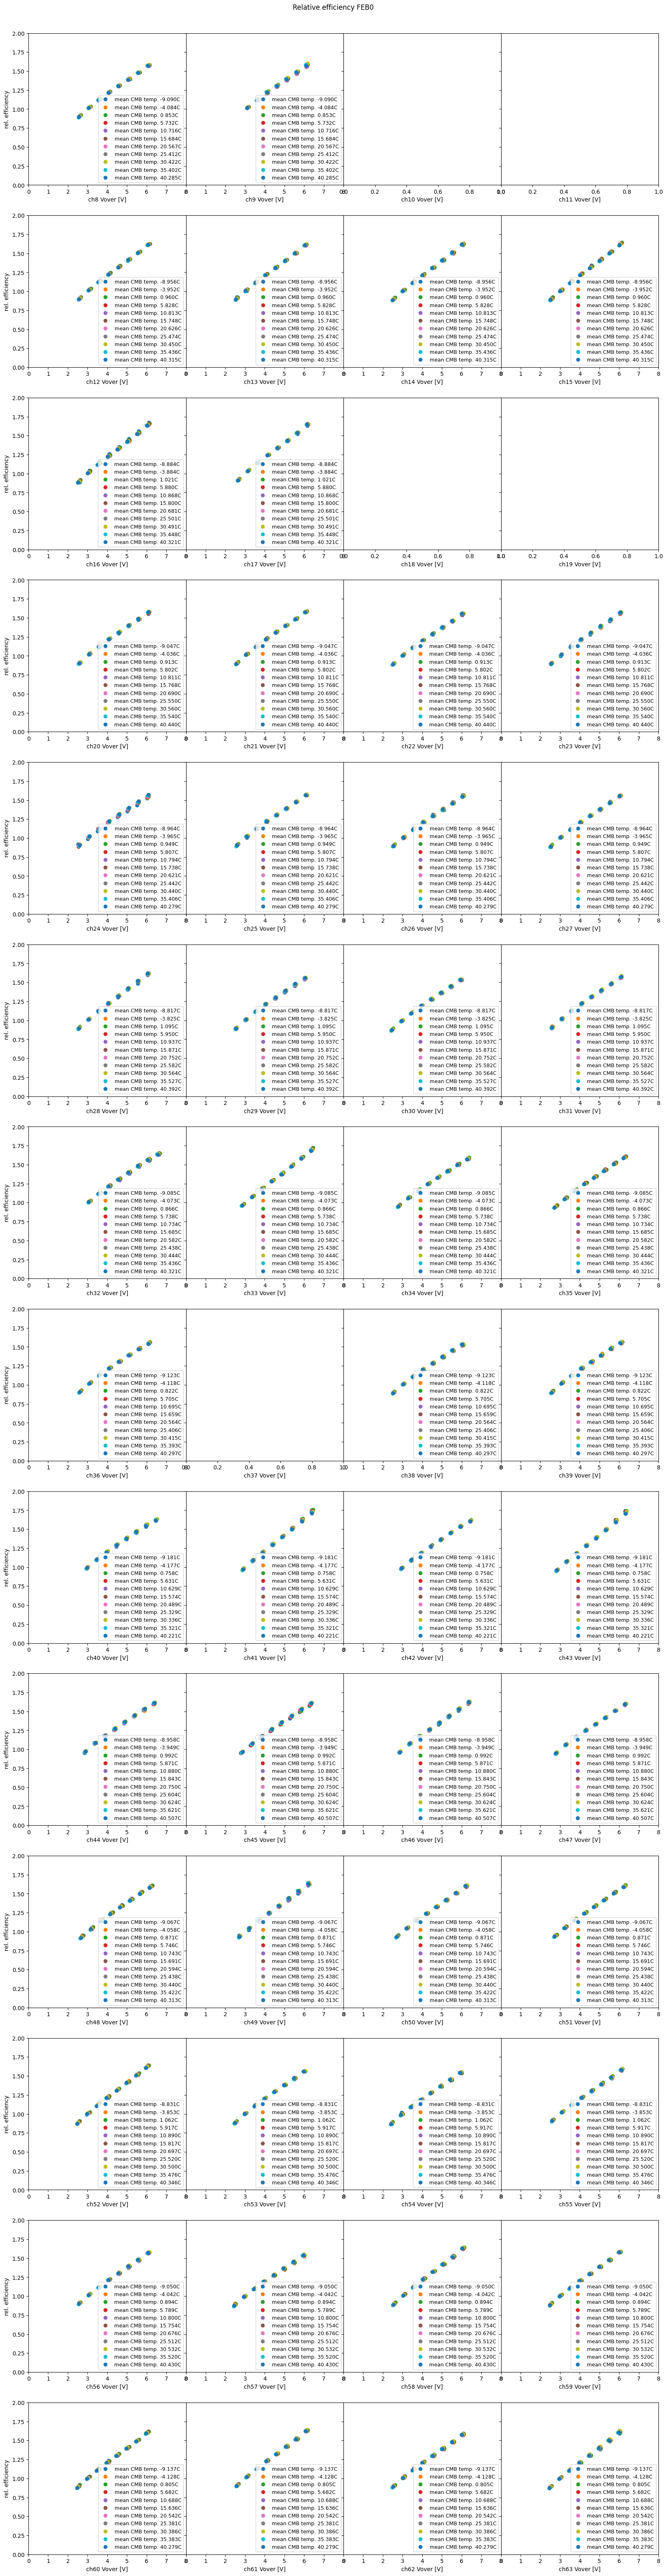

In [7]:
# grid normalized to 1 at 3 V overvoltage
all_x = np.array([])
all_y = np.array([])
maintitle = 'Relative efficiency'
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (5*nc, 5*nr/0.97), sharey = True)
plt.suptitle(maintitle+" FEB0")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.97)
ytitle = 'rel. efficiency'
xtitle = 'Vover [V]'
for index, ax in enumerate(axs.flatten()):
    chan = index + 8
    ax.set_xlabel('ch%i '%chan+xtitle)
    if (index%4 == 0):
        ax.set_ylabel(ytitle)
    if chan in bad_channels:
        continue
    emptyFlag = True
    for tTempSetup in tempSetups:
        df_ = df_scan.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index(drop=True)
        xx = df_['Vover'].astype(float)
        yy = df_['PEsByY0'].astype(float)
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        mask = (yy>0)
        xx=xx[mask]
        yy=yy[mask]
        df_norm_ = df_normalizationAt3VVover.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index(drop=True)
        tNormalization = df_norm_['normalization'].astype(float)[0]
        if yy.size==0:
            print("0PE channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if tNormalization == 0:
            print("Bad normalization channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if True: #xx.size>3
            emptyFlag = False
            tscatter = ax.plot(xx, yy/tNormalization, 'o', label='mean CMB temp. %.3fC'%(meanTemp))
            ax.set_xlim(0.,8.)
            ax.set_ylim(0.,2.)
            all_x = np.append(all_x, xx)
            all_y = np.append(all_y, yy/tNormalization)
    if not emptyFlag:
        ax.legend(fontsize=9)
plt.show()

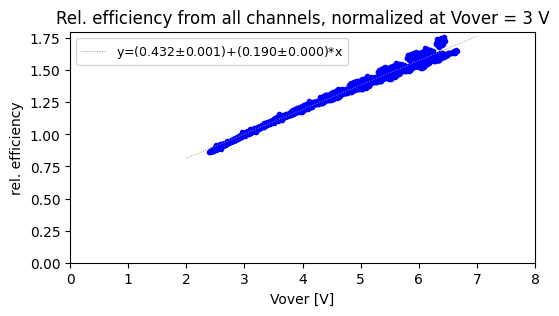

In [8]:
# relative efficiency vs. Vover are so similar across channels that they can be fit together
popt, pcov = curve_fit(func_lin, all_x, all_y)
slope = popt[0]
intercept = popt[1]
std_err = np.sqrt(pcov[0,0])
intercept_stderr = np.sqrt(pcov[1,1])
plt.figure(figsize = (6,3))
plt.plot(all_x, all_y, '.', color = 'b')
plt.plot(np.array([0.5*x for x in range(4, 15)]), slope * np.array([0.5*x for x in range(4, 15)]) + intercept, ':', color = '#929591', linewidth=0.7, 
         label='y=(%.3f$\pm$%.3f)+(%.3f$\pm$%.3f)*x'%(intercept, intercept_stderr, slope, std_err))
plt.title("Rel. efficiency from all channels, normalized at Vover = 3 V")
plt.legend(fontsize=9)
plt.xlabel('Vover [V]')
plt.ylabel('rel. efficiency')
plt.gca().set_xlim(0., 8.)
plt.gca().set_ylim(0., 1.8)
plt.show()

Previous 22.9%/V was calculated for Vset = 54 V, or Vover = 2.5 V. If we renormalize the fitting line above to have y = 1 at Vover = 2.5 V, the slope would be 0.19/(0.432+0.19*2.5) = 20.9%/V. This is not a big difference from the previous result.
We thought we would see ~1/4 or 1/3 overestimation? Is this result consistent? (normalization scheme in intermediate steps in previous analysis? rerun previous analysis uisng new method?)

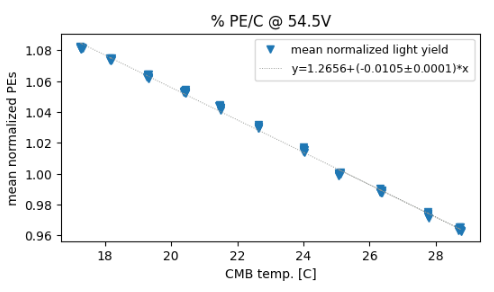

Back to the monitoring CMB. As each increasing degC of temperature is 55.4mV increase in Vbd, with 25 degC 54.5V at roughly 3V Vover, 17~28.7 degC correspond to 3.44V Vover to 2.80V Vover, or light yield of 1.086 to 0.964 => -1.05%/C is mostly SiPM effect, not LED.
The previous analysis -1.267%/C @ 54V converts to -1.22%/C. Some influence from LED, but not as huge as once thought. LED generates heat too, hard to determine the actual temperature change on it. 

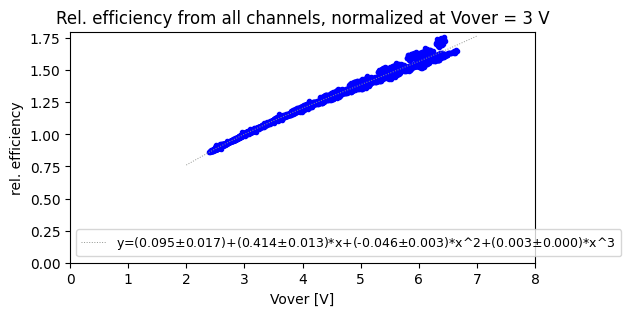

In [9]:
def func_cubic(x, a, b, c, d):
    return a*x*x*x+b*x*x+c*x+d
    
# relative efficiency vs. Vover are so similar across channels that they can be fit together
popt, pcov = curve_fit(func_cubic, all_x, all_y)
a = popt[0]
b = popt[1]
c = popt[2]
d = popt[3]
a_err = np.sqrt(pcov[0,0])
b_err = np.sqrt(pcov[1,1])
c_err = np.sqrt(pcov[2,2])
d_err = np.sqrt(pcov[3,3])
def tfunc(x):
    return a*x*x*x+b*x*x+c*x+d
plt.figure(figsize = (6,3))
plt.plot(all_x, all_y, '.', color = 'b')
dotx = np.array([0.5*x for x in range(4, 15)])
plt.plot(dotx, 
         np.apply_along_axis(tfunc, 0, dotx), ':', color = '#929591', linewidth=0.7, 
         label='y=(%.3f$\pm$%.3f)+(%.3f$\pm$%.3f)*x+(%.3f$\pm$%.3f)*x^2+(%.3f$\pm$%.3f)*x^3'%(d, d_err, c, c_err, b, b_err, a, a_err))
plt.title("Rel. efficiency from all channels, normalized at Vover = 3 V")
plt.legend(fontsize=9)
plt.xlabel('Vover [V]')
plt.ylabel('rel. efficiency')
plt.gca().set_xlim(0., 8.)
plt.gca().set_ylim(0., 1.8)
plt.show()

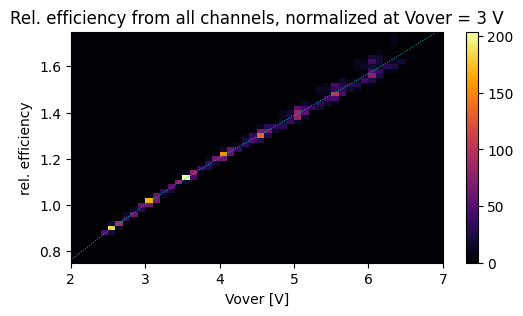

In [10]:
nx = 50 # 2-7V
xwidth = (7.-2.)/50.
ny = 50 # 0.75-1.75
ywidth = (1.75-0.75)/50.

fig, ax = plt.subplots(figsize = (6,3))
hist = ax.hist2d(all_x, all_y, bins = [[xwidth*i+2.0 for i in range(nx+1)], [ywidth*i+0.75for i in range(ny+1)]], cmap='inferno')
ax.plot(dotx, 
        np.apply_along_axis(tfunc, 0, dotx), ':', color = 'c', linewidth=0.7, 
        label='y=(%.3f$\pm$%.3f)+(%.3f$\pm$%.3f)*x+(%.3f$\pm$%.3f)*x^2+(%.3f$\pm$%.3f)*x^3'%(d, d_err, c, c_err, b, b_err, a, a_err))
plt.colorbar(hist[3], ax=ax, location='right')
plt.title("Rel. efficiency from all channels, normalized at Vover = 3 V")
plt.xlabel('Vover [V]')
plt.ylabel('rel. efficiency')
plt.gca().set_xlim(2., 7.)
plt.gca().set_ylim(0.75, 1.75)
plt.show()

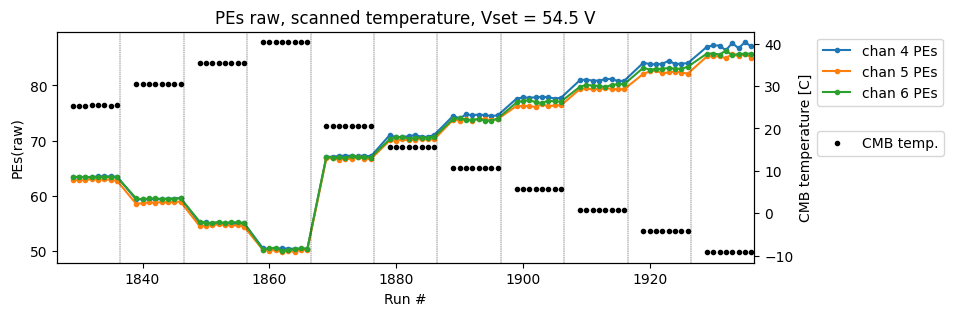

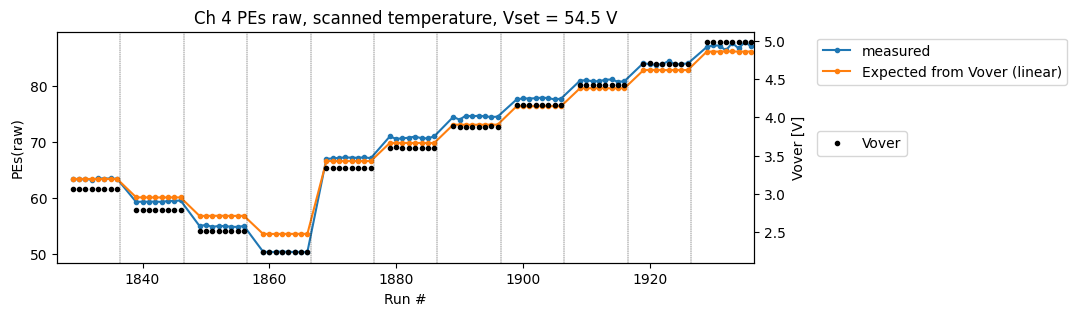

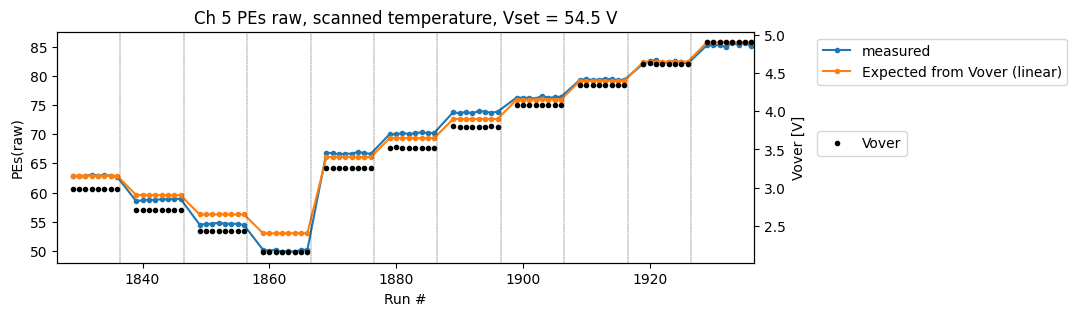

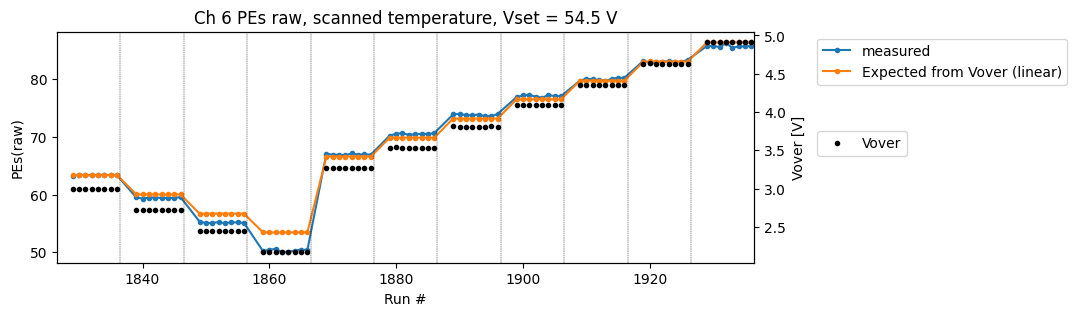

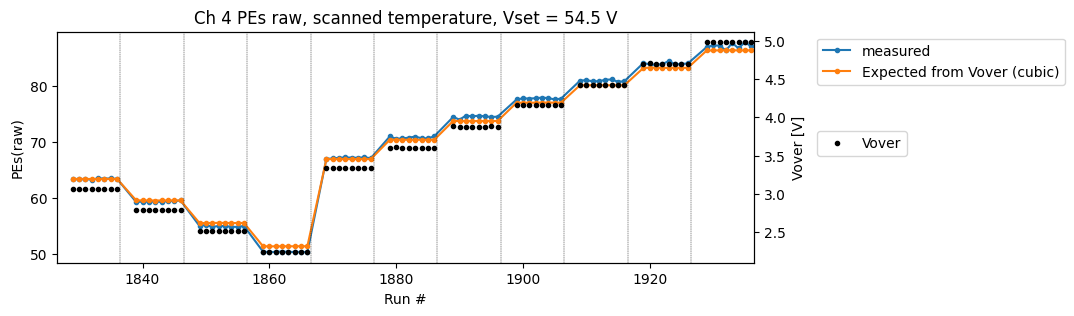

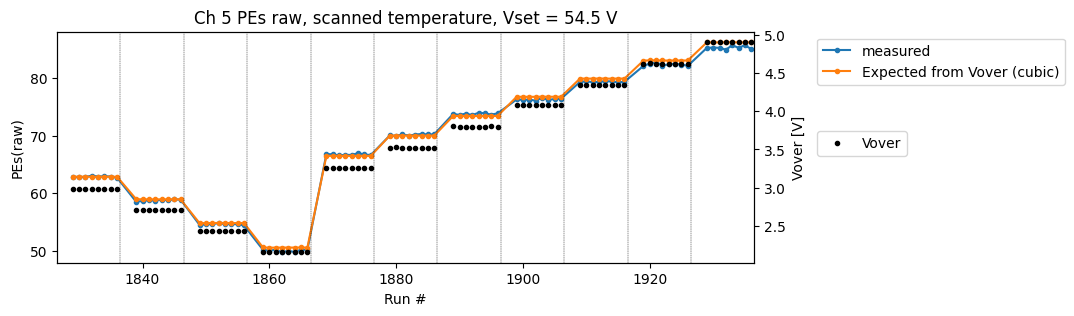

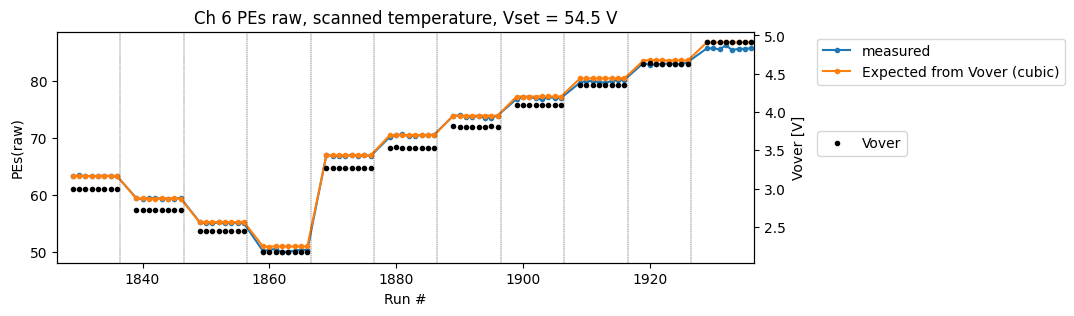

In [11]:
## verify channel 4-7

from __future__ import print_function
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy import stats

topdir = os.path.dirname(os.path.abspath("__file__"))
analysis_dir = os.path.join(topdir,"analysis_root_files")
data_pklname = os.path.join(analysis_dir,"tempScanSiDetRun2.pkl")
SPE_pklname = os.path.join(analysis_dir,"tempScanSiDetRun2SPE.pkl")

with open(data_pklname, 'rb') as f:
    df = pickle.load(f)
df = df.query("VoverN > 2.0").reset_index()

with open(SPE_pklname, 'rb') as f:
    df_SPE_clean = pickle.load(f)
    df_54V_Temp = pickle.load(f)
    df_55V_Temp = pickle.load(f)
    df_Vbd = pickle.load(f)

runs = df['run'].unique()
runs = np.sort(runs)
FEBs = df['FEB'].unique()
FEBs = np.sort(FEBs)
tempSetups = df['tempSetup'].unique()
tempSetups = np.sort(tempSetups)

Vbd_dict = {'4':51.69, '5':51.77, '6':51.76} #NIU @ 30degC

Vover = []
df_checkPEs = df.query("ch < 7 & ch > 3").reset_index(drop=True)
for index, row in df_checkPEs.iterrows():
    tChan = row['ch']
    VbdPerC = 0.0554
    tTemp = row['CMBtemp']
    tVppN = 54.5
    tVbd = Vbd_dict[str(tChan)] + VbdPerC* (tTemp-30.)
    tVover = tVppN - tVbd
    Vover.append(tVover)
# print(Vover)
df_checkPEs.loc[:, 'Vover'] = np.array(Vover)

PEfactor_lin = {} # @ 3V Vover
PEfactor_cubic = {} # @ 3V Vover
for chan in range(4,7):
    df_ = df_checkPEs.query("ch == %i & tempSetup == 25"%chan).reset_index(drop=True)
    PEfactor_lin.update({str(chan):np.mean(df_['PEs'])/(np.mean(df_['Vover'])*0.190+0.432)})
    PEfactor_cubic.update({str(chan):np.mean(df_['PEs'])/(tfunc(np.mean(df_['Vover'])))})

PEsExpected_lin = []
PEsExpected_cubic = []
for index, row in df_checkPEs.iterrows():
    tChan = row['ch']
    PEsExpected_lin.append(PEfactor_lin[str(tChan)]*(row['Vover']*0.190+0.432))
    PEsExpected_cubic.append(PEfactor_cubic[str(tChan)]*(tfunc(row['Vover'])))
# print(PEsExpected)
df_checkPEs.loc[:, 'PEsExpected_lin'] = np.array(PEsExpected_lin)
df_checkPEs.loc[:, 'PEsExpected_cubic'] = np.array(PEsExpected_cubic)

plt.figure(figsize = (9,3))
for chan in range(4,7):
    df_ = df_checkPEs.query('ch == %i'%chan)
    plt.plot(df_['run'], df_['PEs'],'.-',
             label='chan %i PEs'%chan)
plt.title("PEs raw, scanned temperature, Vset = 54.5 V")
plt.xlabel("Run #")
plt.ylabel("PEs(raw)")
plt.gca().set_xlim(np.min(runs)-2.5, np.max(runs)+0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.08, 1.0))
ax2 = plt.gca().twinx()
ax2.plot(df_['run'], df_['CMBtemp'],'.', color='k', linestyle='none', label='CMB temp.')
ax2.set_ylabel("CMB temperature [C]")
plt.legend(loc='upper left', bbox_to_anchor=(1.08, 0.6))
for iTemp in range(11):
    plt.axvline(x=np.min(runs)+10*iTemp-2.5, color='k', linestyle='--', linewidth=0.3)
plt.show()

for chan in range(4,7):
    plt.figure(figsize = (9,3))
    df_ = df_checkPEs.query('ch == %i'%chan)
    plt.plot(df_['run'], df_['PEs'],'.-', label='measured')
    plt.plot(df_['run'], df_['PEsExpected_lin'],'.-', label='Expected from Vover (linear)')
    plt.title("Ch %i PEs raw, scanned temperature, Vset = 54.5 V"%chan)
    plt.xlabel("Run #")
    plt.ylabel("PEs(raw)")
    plt.gca().set_xlim(np.min(runs)-2.5, np.max(runs)+0.5)
    plt.legend(loc='upper left', bbox_to_anchor=(1.08, 1.0))
    ax2 = plt.gca().twinx()
    ax2.plot(df_['run'], df_['Vover'],'.', color='k', linestyle='none', label='Vover')
    ax2.set_ylabel("Vover [V]")
    plt.legend(loc='upper left', bbox_to_anchor=(1.08, 0.6))
    for iTemp in range(11):
        plt.axvline(x=np.min(runs)+10*iTemp-2.5, color='k', linestyle='--', linewidth=0.3)
    plt.show()

for chan in range(4,7):
    plt.figure(figsize = (9,3))
    df_ = df_checkPEs.query('ch == %i'%chan)
    plt.plot(df_['run'], df_['PEs'],'.-', label='measured')
    plt.plot(df_['run'], df_['PEsExpected_cubic'],'.-', label='Expected from Vover (cubic)')
    plt.title("Ch %i PEs raw, scanned temperature, Vset = 54.5 V"%chan)
    plt.xlabel("Run #")
    plt.ylabel("PEs(raw)")
    plt.gca().set_xlim(np.min(runs)-2.5, np.max(runs)+0.5)
    plt.legend(loc='upper left', bbox_to_anchor=(1.08, 1.0))
    ax2 = plt.gca().twinx()
    ax2.plot(df_['run'], df_['Vover'],'.', color='k', linestyle='none', label='Vover')
    ax2.set_ylabel("Vover [V]")
    plt.legend(loc='upper left', bbox_to_anchor=(1.08, 0.6))
    for iTemp in range(11):
        plt.axvline(x=np.min(runs)+10*iTemp-2.5, color='k', linestyle='--', linewidth=0.3)
    plt.show()
    